## Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [3]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Creating Gaussian Process

In [4]:
lower_in = 0
upper_in = 10
num_train = 50
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1).to(torch.device('cuda'))
y_train = f(x_train).to(torch.device('cuda'))

kernel_sin = SinusoidalKernel(amplitude=1.0, length_scale=1.0, period=0.001).to(torch.device('cuda'))
kernel_exp = RBFKernel(length_scale=1.0, amplitude=1.0).to(torch.device('cuda'))

gp_sin = GaussianProcessRegressor(kernel_sin, noise=0.0, max_iter=10_000, restarts=0, batch_size=num_train, lr=0.001)
gp_sin = gp_sin.fit(x_train, y_train)

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.0, max_iter=10_000, restarts=0, batch_size=num_train, lr=0.001)
gp_exp = gp_exp.fit(x_train, y_train)

Iteration 0, Loss: 11472.9912109375
Iteration 100, Loss: 0.677215576171875
Iteration 200, Loss: -54.92741394042969
Iteration 300, Loss: -67.73777770996094
Iteration 400, Loss: -72.90007019042969
Iteration 500, Loss: -75.87643432617188
Iteration 600, Loss: -76.8577651977539
Iteration 700, Loss: -78.14511108398438
Iteration 800, Loss: -78.92750549316406
Iteration 900, Loss: -79.1532211303711
Iteration 1000, Loss: -79.48754119873047
Iteration 1100, Loss: -80.61578369140625
Iteration 1200, Loss: -79.9440689086914
Iteration 1300, Loss: -79.60797119140625
Iteration 1400, Loss: -79.95841979980469
Iteration 1500, Loss: -80.10195922851562
Iteration 1600, Loss: -80.02017211914062
Iteration 1700, Loss: -79.95034790039062
Iteration 1800, Loss: -81.09652709960938
Iteration 1900, Loss: -80.87623596191406
Iteration 2000, Loss: -80.80101776123047
Iteration 2100, Loss: -79.56008911132812
Iteration 2200, Loss: -80.79109191894531
Iteration 2300, Loss: -80.1549072265625
Iteration 2400, Loss: -80.496948242

## Plotting GP Samples

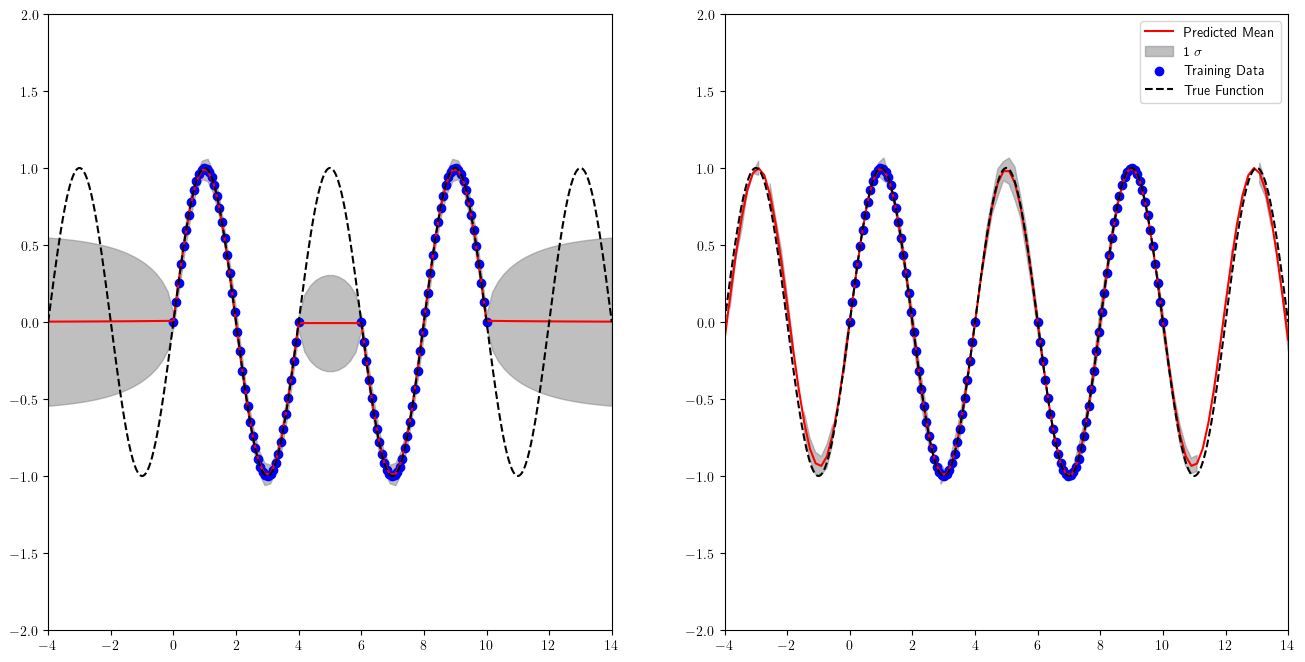

In [5]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

x_test = torch.linspace(-4, 14, 100, device=torch.device('cuda')).unsqueeze(1)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for gp, ax in zip([gp_exp, gp_sin], axs):

    y_pred, y_std = gp.predict(x_test, return_std=True)

    ax.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean')

    upper = y_pred.squeeze() + 1 * y_std
    lower = y_pred.squeeze() - 1 * y_std

    ax.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color='grey', label=r'1 $\sigma$')

    ax.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='b', marker='o', label='Training Data')

    ax.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function')

    ax.set_xlim(-4, 14)
    ax.set_ylim(-2, 2)

plt.legend()

plt.show()